### Development notebook for smoothed seismicity
- Just smooth seismicity over a given kernel
- ... in particular, a nETAS (not-ETAS) PL function
- Experiment with different indexing strategies
  - Consider simple numpy indexing syntax, X[x>x1 and x<x2 and y>y1 and y<y2], etc.
  - Revisit rtree, etc.
- *Like* ETAS with $p=0$, but simpler, and more explicit; $sum(elements) = N_{eq}$


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
import global_etas_auto as ggep
from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

failed while loading urllib and/or urllib. maybe python 3.x?


/home/myoder/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [60]:
# get a catalog... for now, use the gep fancy ETAS catalogs... (note there is an _mpp version...)
day2sec = 24*3600
#
lats = [31., 41.]
lons=[-120., -110.]
mc=2.5
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
cat_len=30
t1 = to_dt-dtm.timedelta(days=cat_len)
#
class Seismicity_Smoother(object):
    def __init__(self, lats, lons, cat=None, mc=2., date_range=[t1, to_dt], cat_len=60, d_lat=.1, d_lon=.1,
                 map_lats=None, map_lons=None, etas_range_factor=25., t_now=None, do_omori=False):
        cat_len=int(cat_len)
        if date_range is None:
            date_range = [None, None]
        if date_range[1] is None:
            date_range[1] = dtm.datetime.now(pytz.timezone('UTC'))
        if date_range[0] is None:
            date_range[0] = date_range[1]-dtm.timedelta(days=cat_len)
        #
        if t_now is None:
            t_now = dtm.datetime.now(pytz.timezone('UTC'))
        #
        lats = numpy.sort(lats)
        lons = numpy.sort(lons)
        #
        delta_lat = -numpy.subtract(*lats)
        delta_lon = -numpy.subtract(*lons)
        #print('*** ', delta_lat, delta_lon)
        #
        if map_lats is None:
            map_lats = [None, None]
        if map_lats[0] is None: map_lats[0] = lats[0] - 0.0*delta_lat
        if map_lats[1] is None: map_lats[1] = lats[1] + 0.10*delta_lat
        #
        if map_lons is None:
            map_lons = [None, None]
        if map_lons[0] is None: map_lons[0] = lons[0] - 0.0*delta_lon
        if map_lons[1] is None: map_lons[1] = lons[1] + 0.0*delta_lon 
        #
            
        if cat is None:
            cat = gep.make_ETAS_catalog(lats=lats, lons=lons, mc=mc, date_range=date_range)
        #
        ## TODO: handle case of a simple catalog; run through make_ETAS_catalog() to get formatted catalog.
        #    test this to see if we need to pass parameters.
        print('*** ', cat.dtype.names)
        if not hasattr(cat, 'dtype') or not 'r_0' in cat.dtype.names:
            cat = gep.make_ETAS_catalog(incat=cat)
        #
        print('*** **', cat.dtype.names)
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
        self.XYZ = self.calc_seismicity_field()
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
        #
    #
    def calc_seismicity_field(self, n_cpu=1):
        # TODO: pass lat, lon, etc. prams to facilitate MPP.
        # ... and let's try to MPP this within the function, quasi-recursively.
        #
        t_now = mpd.date2num(self.t_now)
        #
        min_lon = self.map_lons[0]
        max_lon = self.map_lons[1]
        min_lat = self.map_lats[0]
        max_lat = self.map_lats[1]
        d_lon = self.d_lon
        d_lat = self.d_lat
        #
        # TODO: enable MPP. the easiest, but sloppy approach is to initialize XYZ, slice it up
        # and pass to processes. we can save a bit of time by indexing this, so we initialize XYZ_p
        # on each processor p and don't have to pass a large, mostly empty object. we might also look into
        # not passing, and recreating, the x,y components, but in the end that should be a small
        # optimization.
        #
        if n_cpu > 1:
            n_total = int((max_lat-min_lat)/d_lat) * int((max_lon)-min(lon)/d_lon)
            n0 = int(numpy.ceil(n_total/n_cpu))
            #for n in n_cpu:
            #    k0 = n*n0
            #    k1 = min(n_total, (n+1)*n0)
            #    #
            #    # NOTE: upon closer examination, this is tricky to now create an array with a partil row/column
            #    #  of one index and a complete row/index of another. we could just do it with an 'if'
            #    #  exclusion -- to the itertools.product() and just if-skip the parts we don't want,
            #    #  or start at the previous row and if-skip only one partial index...
            #    #  but really, it's only one iteration, so it's not too expensive to SPP and pass or to do on all
            #    #  processes, or just pass potentially less even pieces -- maybe pass lat or lon strips.
            #    #  For load balancing, it might be smart to pre-construct the array (or at least an index)
            #    #  and then randomly distribute -- so maybe pass an index of 0-(n-1) to each process;
            #    #  each process then constructs those [[x,y,0], ...] initializations, computes, returns
            #    #  and we recompile.
            indices = numpy.arange(len(cat), dtype=cat)
            R_index = numpy.random.random(size=len(indices))
            d_k = 1./n_cpu
            #
            # this is going to look non-optimally slow, but we want to avoid floating point errrors that
            #  might assign duplicates or skip an entry. each value goes to one place...
        # 
        #
        #XYZ = numpy.array([[x,y,0.] for y,x in itertools.product(numpy.arange(min_lat, max_lat+d_lat, d_lat),
        #                                                        numpy.arange(min_lon, max_lon+d_lon, d_lon)
        #                                                        )])
        XYZ = numpy.array([[x,y,0.] for y,x in itertools.product(numpy.arange(min_lat, max_lat, d_lat),
                                                                numpy.arange(min_lon, max_lon, d_lon)
                                                                )])
        #
        cat = self.cat
        #
        # so this started as a simple smoothed seismicity viewer, but now we're looking at a full ETAS
        #  reboot. 
        #
        # NOTE: this approach will cost us a little bit for just-seismicity cases, but it will simplify our
        #  code quite a bit.
        if self.do_omori:
            delta_t = (t_now - mpd.date2num(cat['event_date']))*day2sec
            idx_dt = delta_t>=0.
            orates = ((1./cat['tau']) * (cat['t_0'] + delta_t*day2sec )**(-cat['p']))[idx_dt]
        else:
            orates = numpy.ones(len(cat))
            idx_dt = numpy.array([True for _ in orates])
        orates = orates[idx_dt]
        cat = cat[idx_dt]
        # work on indexing later (and note, we'll need to handle global-warap-around). for now, just loop-loop:
        #q = cat['q']
        #r_0 = cat['r_0]']
        #chi_norm = q*(q-1.0)*(r_0**(q-1.0))
        ##
        #del q,r_0
        #
        # pre-compute orate/2*pi...
        #
        # for  (k, (x,y,z)), (rw_eq, orate) in itertools.product(enumerate(XYZ), cat):
        #for  (k, (x,y,z)), (rw_eq, orate) in itertools.product(enumerate(XYZ), zip(cat, orates)):
        # pre-compute the rate vector:
        orates = orates/(2.*math.pi*cat['chi_norm'])
        # TODO: code great_circle()? there is some exception handling, and other stuff, that is problematic
        #  for vectorization. if we pre-qualify data (lat, lon vals, etc. it might be possible to numpy
        #  it to get a performance boost.
        for  (k, (x,y,z)), ((R0, lat, lon, q), orate) in itertools.product(enumerate(XYZ),
                                                            zip(cat[['r_0', 'lat', 'lon', 'q']], orates)):
            #print('*** ', k, x,y,z, rw_eq, '** **', rw_eq['chi_norm'])
            #XYZ[k][2] += orate*(1./(math.pi*2.*rw_eq['chi_norm']))*(rw_eq['r_0']
            #                                                + geopy.distance.great_circle((y,x),
            #                                                (rw_eq['lat'], rw_eq['lon'])).km)**(-1.-rw_eq['q'])
            XYZ[k][2] += orate*(R0 + geopy.distance.great_circle((y,x),
                                                            (lat, lon)).km)**(-1.-q)
        #
        # NOTE: geopy.dicatnce.greate_circle() won't handle numpy arrays, as per internal boolean logic.
        #for k, (x,y,z) in enumerate(XYZ):
        #         XYX[k][2] = numpy.sum(orates*(cat['r_0'] +  geopy.distance.great_circle((y,x),
        #                                                    (cat['lat'], cat['lon'])).km)**(-(1.+cat['q'])))
            
        return numpy.core.records.fromarrays(zip(*XYZ), dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')])
        
#
lon0 = -149.937
lat0 = 61.340 
d_lat = 7.
d_lon = 7.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
mc = 3.

#
#SSm = Seismicity_Smoother(lats=lats, lons=lons, mc=mc, date_range=[t1, to_dt], cat_len=25)
SSm = Seismicity_Smoother(lats=lats, lons=lons, mc=mc, date_range=[None, to_dt], cat_len=5*365)
#

NOTE: loading from comcat.
***  ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')
*** ** ('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'chi_norm', 'e_vals', 'e_vecs', 'N_eig_cat')


***  140 155 21700 21700
total:  2882.6298504221427 5076


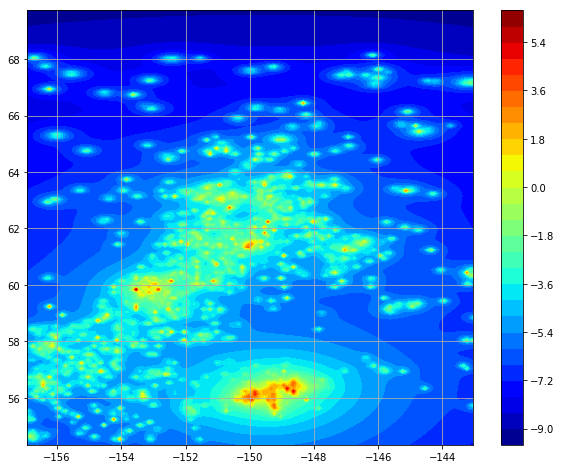

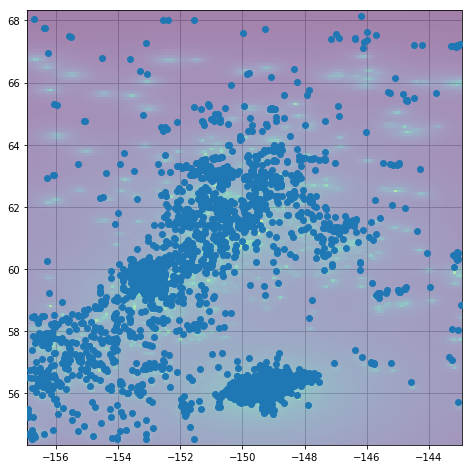

In [62]:
n_X = len(numpy.unique(SSm.XYZ['x']))
n_Y = len(numpy.unique(SSm.XYZ['y']))

fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()

ctrs = ax.contourf(SSm.XYZ['x'].reshape(n_Y, n_X), SSm.XYZ['y'].reshape(n_Y, n_X),
            numpy.log(SSm.XYZ['z']).reshape(n_Y, n_X), 25, cmap='jet')
plt.colorbar(ctrs, cax=None, ax=ax, cmap='jet')

#ax.plot(SSm.cat['lon'], SSm.cat['lat'], ls='', marker='o', zorder=11)
#

#
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()

# n_X = len(set(SSm.cat['lon']))
# n_Y = len(set(SSm.cat['lat']))
#ax.contourf(X = numpy.reshape(SSm.XYZ['x'], (n_Y, n_X)) , Y=numpy.reshape(SSm.XYZ['y'], (n_Y, n_X)),
print('*** ', n_X, n_Y, n_X*n_Y, len(SSm.XYZ))
ax.imshow(numpy.reshape(numpy.log(SSm.XYZ['z']), (n_Y, n_X)), extent= numpy.append(SSm.lons, SSm.lats) ,
          origin='lower', alpha=.5, zorder=2)

ax.plot(SSm.cat['lon'], SSm.cat['lat'], ls='', marker='o', zorder=11)
#
print('total: ', numpy.sum(SSm.XYZ['z']), len(SSm.cat))


In [41]:
print(len(SSm.cat))

46


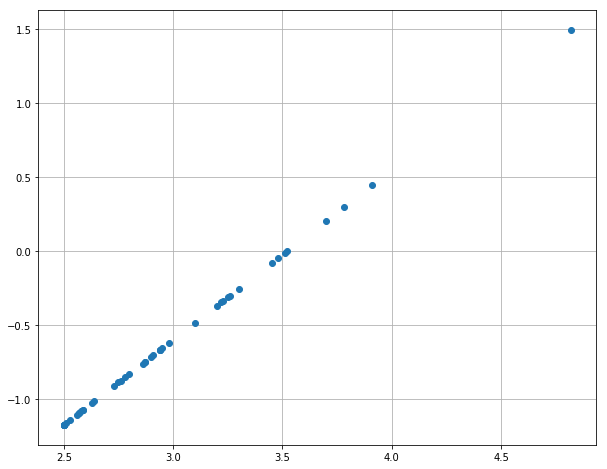

In [7]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
#
ax.plot(SSm.cat['mag'], numpy.log(SSm.cat['L_r']), ls='', marker='o')
#print(SSm.cat['L_r'][0:5])

In [8]:
print(SSm.XYZ[0:10])
print(len(set(SSm.XYZ['x'])), len(set(SSm.XYZ['y'])))

[(-120. , 31., 1.00107058e-05) (-119.9, 31., 1.04957133e-05)
 (-119.8, 31., 1.10146051e-05) (-119.7, 31., 1.15703270e-05)
 (-119.6, 31., 1.21660662e-05) (-119.5, 31., 1.28052462e-05)
 (-119.4, 31., 1.34915078e-05) (-119.3, 31., 1.42286699e-05)
 (-119.2, 31., 1.50206618e-05) (-119.1, 31., 1.58714187e-05)]
101 112


In [9]:
print(SSm.cat['chi_norm'])

[0.09201901 0.10802404 0.1928884  0.30823187 0.13322687 0.09201901
 0.14524187 0.21821145 0.16634908 0.23209365 0.1222058  0.09548804
 0.15834043 0.40432881 0.1603057  0.44626397 0.10031769 0.246859
 0.09316112 0.10936479 0.29703396 0.15834043 0.10282337 0.15834043
 0.15071735 1.60966197 0.2236618  0.1015628  0.12681285 0.14346127
 0.31985192 0.23497432 0.32382182 0.09908785 0.10282337 0.1299803
 0.09201901 0.09201901 0.09201901 0.14524187 0.52388345 0.10031769
 0.09201901 0.15258801 0.12525818 0.22643782]


In [18]:
print(SSm.cat['event_date'].astype(float)[0:5])
print(mpd.date2num(SSm.cat['event_date'][0:5]))

[1.54131114e+15 1.54136587e+15 1.54136710e+15 1.54148615e+15
 1.54148732e+15]
[737002.24927373 737002.8827647  737002.89699306 737004.2749022
 737004.28846437]
